
# kaggleのデータセットを用いてモデルを構築する

### 目的：クラウドファンディングが成功するかを予測するモデルを構築する
### Kickstarter Projects URL:https://www.kaggle.com/kemical/kickstarter-projects

・利用するデータ「ks-projects-201801.csv」（データ数：378,661行15列）

## 手順
- 1.データ読込
- 2.データ前処理
- 3.モデル生成
- 4.モデル評価

| 列 | 項目 | 項目名 | 欠損有無 | 利用有無 |
| :--- | :--- | :--- | :---: | :---: |
|  1 | ID| 識別ID | - | 不要と思われる為除外 |
|  2 | name |名称 | 欠損あり | 不要と思われる為除外 |
|  3 | category |カテゴリ | - | ○ |
|  4 | main_category |主なカテゴリ | - | ○ |
|  5 | currency |使用通貨 | - | ○ |
|  6 | deadline |締切日時 | - | ○※期間算出用 |
|  7 | goal |目標調達資金額 | - | ×※usd_goal_realを使うため除外 |
|  8 | launched |開始日時 | - | ○※期間算出用,月,日,時間を抽出 |
|  9 | pledged |集まった資金 | - | 予測できないため除外 |
| 10 | state |プロジェクトの状態 | - | ○※成功と失敗のみ抽出 |
| 11 | backers |支援者数 | - | 予測できないため除外 |
| 12 | country|国 | - | ○ |
| 13 | usd_pledged |集まった資金（米ドル） | 欠損あり | 予測できないため除外 |
| 14 | usd_pledged_real |集まった資金（米ドル） | - | 予測できないため除外 |
| 15 | usd_goal_real |目標金額（米ドル） | - | ○ |


▼ 行列数
(378661, 15)

▼ 期間の外れ値を確認


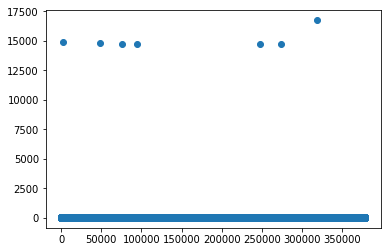


▼ 目標金額の外れ値を確認


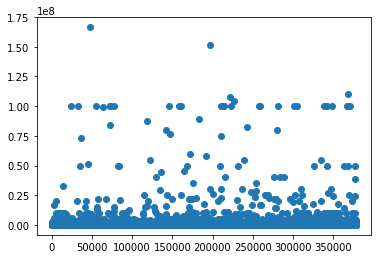


▼ 開始月別の成功率


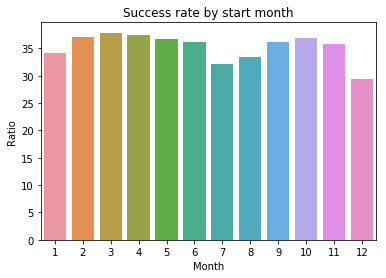


▼ 開始時間別の成功率


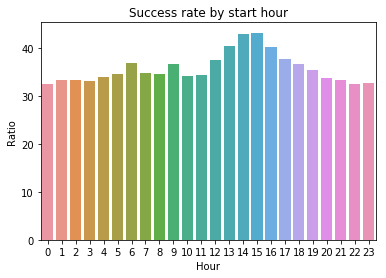

In [311]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix,precision_recall_fscore_support
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

import warnings
from collections import Counter

# ================================================
# ◆ 1.データ読込
# ================================================
df= pd.read_csv('./ks-projects-201801.csv',parse_dates=['deadline', 'launched'])

print("\n▼ 行列数")
print(df.shape)

# ================================================
# ◆ 2.前処理
# ================================================

# ------------------------------------------------
# 2-1.項目の選定
# ------------------------------------------------
# 不要と考えられる項目を除外
df = df.drop(['ID'], axis=1)           # モデル作成に不要と考え除外
df = df.drop(['name'], axis=1)         # 欠損があり、モデル作成に不要と考え除外
df = df.drop(['goal'], axis=1)         # usd_goal_realとほぼ等しい為、除外
df = df.drop(['currency'], axis=1)     # countryを利用する為、除外

# 事前に予測できない項目を除外
df = df.drop(['backers','pledged','usd pledged','usd_pledged_real'], axis=1)

#print("\n▼ 先頭5行")
#print(df.head(5))

#print("\n▼ 基本統計量")
#print(df.describe())

#print("\n▼ 欠損項目抽出")
#print(df.isnull().sum()[df.isnull().sum()>0])

# クラウドファンディングの期間(period)の算出
df['period'] = (df['deadline'] - df['launched']).dt.days

# ------------------------------------------------
# 2-2.数値項目の外れ値確認
# ------------------------------------------------
# 期間
print("\n▼ 期間の外れ値を確認")
plt.scatter(df.index, df['period'])
plt.show()
# 開始日時が不正なデータ5件を除外（1970-01-01 01:00:00）
df = df.query('period < 10000')

# 目標金額
print("\n▼ 目標金額の外れ値を確認")
plt.scatter(df.index, df['usd_goal_real'])
plt.show()
# 2件の外れデータを除外
df = df.query('usd_goal_real < 125000000')

# ------------------------------------------------
# 2-3.開始時期（月、日、時間）の影響度を確認
# ------------------------------------------------
df['launched_Month'] = df['launched'].dt.month
#df['launched_Day'] = df['launched'].dt.day    # 正答率が下がった為、除外
df['launched_Hour'] = df['launched'].dt.hour
df = df.drop(['launched','deadline'], axis=1)

# 開始月別成功率グラフ
print("\n▼ 開始月別の成功率")
successrate = []
for month in range(1, 13):
    success = len (df[(df['launched_Month'] == month) & (df['state'] == 'successful')])
    overall = len (df[df['launched_Month'] == month])
    successrate.append((month, success/ overall * 100)) # 月の成功件数/月の件数
    #print("{:.0f}月----> {:.1f}%".format(month, success/ overall * 100))

successrate = pd.DataFrame(successrate, columns = ["Month","Rate"])
ax = sns.barplot(x="Month", y="Rate", data=successrate)  
ax.set_title("Success rate by start month")
ax.set_xlabel("Month")
ax.set_ylabel("Ratio")
plt.show()

# 開始時間別成功率グラフ
print("\n▼ 開始時間別の成功率")
successrate = []
for hour in range(0, 24):
    success = len (df[(df['launched_Hour'] == hour) & (df['state'] == 'successful')])
    overall = len (df[df['launched_Hour'] == hour])
    successrate.append((hour, success/ overall * 100)) # 時間の成功件数/時間の件数
    #print("{:.0f}時----> {:.1f}%".format(hour, success/ overall * 100))

successrate = pd.DataFrame(successrate, columns = ["Hour","Rate"])
ax = sns.barplot(x="Hour", y="Rate", data=successrate)  
ax.set_title("Success rate by start hour")
ax.set_xlabel("Hour")
ax.set_ylabel("Ratio")
plt.show()



▼ 項目値のバリエーション数
category            159
main_category        15
state                 6
country              23
usd_goal_real     50336
period               92
launched_Month       12
launched_Hour        24
dtype: int64

▼ State集計
failed        197717
successful    133956
canceled       38773
undefined       3562
live            2799
suspended       1845
Name: state, dtype: int64

▼ Stateの種類（%）


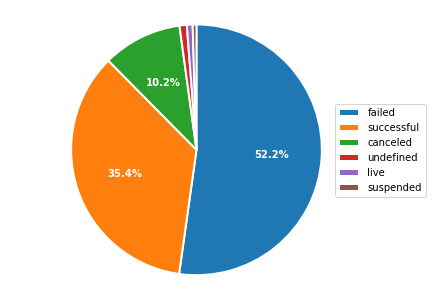


▼ State集計（成功と失敗のみ）
failed        197717
successful    133956
Name: state, dtype: int64

▼ 行列数
(331673, 8)

▼ データのヒストグラムを確認


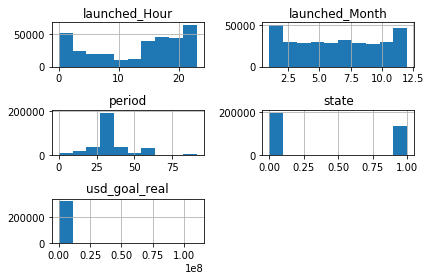

In [312]:
# ------------------------------------------------
# 2-4.目的変数（state）の前処理
# ------------------------------------------------

print("\n▼ 項目値のバリエーション数")
print(df.nunique())

print("\n▼ State集計")
print(df["state"].value_counts())

print("\n▼ Stateの種類（%）")
per_state = round(df["state"].value_counts() / len(df["state"]) * 100,2)
values = list(per_state.values)

# 円グラフ
plt.figure(figsize=(5,5))
plt.pie(values, labels=list(per_state.index),
        wedgeprops={'linewidth': 2,'edgecolor':"white"},
        textprops={'color': "white", 'weight': "bold"},
        counterclock=False,
        startangle=90, 
        autopct=lambda p: '{:.1f}%'.format(p) if p >= 2.5 else '' #2.5%以下の構成要素は数値を非表示（後述）)
       )

# 凡例の表示
lgnd=plt.legend(bbox_to_anchor=(1.0, 0.25, 1.55, 0.5), loc="center left", borderaxespad=0.)
plt.axis('equal')
plt.show()

# 状態が成功または失敗のデータを抽出
df = df[(df['state'] == 'successful') | (df['state'] == 'failed')]

print("\n▼ State集計（成功と失敗のみ）")
print(df["state"].value_counts())

# 状態が成功ならば（1：True），失敗であれば（0：False）に変更
df['state'] = df['state'].map({'failed': 0,'successful': 1})

print("\n▼ 行列数")
print(df.shape)

# 各項目のヒストグラムを表示
print("\n▼ データのヒストグラムを確認")
viz = df[df.columns]
viz.hist()
plt.tight_layout()
plt.show()

In [313]:
# ------------------------------------------------
# 2-5.ダミー変換
# ------------------------------------------------

df = pd.get_dummies(df, columns=['main_category','category', 'country','launched_Month','launched_Hour'])

# ------------------------------------------------
# 2-6.データ標準化
# ------------------------------------------------
scaler = StandardScaler()
df['usd_goal_real'] = scaler.fit_transform(df.loc[:, ['usd_goal_real']])
df['period'] = scaler.fit_transform(df.loc[:, ['period']])

df.index.name="id"

print("\n▼ 行列数")
print(df.shape)

print("\n▼ 先頭5行表示")
print(df.head(5))

#print("\n▼ 基本統計量")
#print(df.describe())

# 相関係数をヒートマップにして可視化
#df.corr()
#plt.figure(figsize=(25, 25)) 
#sns.heatmap(df.corr(), square=True, cmap='Blues')
#plt.show()



▼ 行列数
(331673, 236)

▼ 先頭5行表示
    state  usd_goal_real    period  main_category_Art  main_category_Comics  \
id                                                                            
0       0      -0.037593  1.969987                  0                     0   
1       0      -0.010167  2.048645                  0                     0   
2       0       0.004285  0.868777                  0                     0   
3       0      -0.034254 -0.311090                  0                     0   
5       1       0.009103  0.082199                  0                     0   

    main_category_Crafts  main_category_Dance  main_category_Design  \
id                                                                    
0                      0                    0                     0   
1                      0                    0                     0   
2                      0                    0                     0   
3                      0                    0               

In [314]:
# ================================================
# ◆ 3.モデル作成
# ================================================
X = df.drop('state', axis=1).values # 説明変数
y = df['state'].values              # 目的変数

# ロジスティック回帰モデル生成
clf = SGDClassifier(loss='log',           # ロジスティック回帰を指定
                    penalty='none',       # 正則化を入れる場合はL1､L2→Day2で実施
                    max_iter=10000,       # 繰り返し計算時の強制的終了値、誤差が収束すれば利用しない。
                    fit_intercept=True,   # 切片を有効にするかどうか
                    random_state=1234,    # 乱数のシード
                    tol=1e-3              # 収束する誤差の指定
                   )

# 学習
clf.fit(X, y)

# リストへ変換
n_features = list(df.drop('state', axis=1).columns)
fti = np.reshape(clf.coef_[0], -1).tolist()

print("\n▼ 回帰係数を表示")
#print('w0 = {:.3f}'.format(clf.intercept_[0]))
for i, feature in enumerate(n_features):
    print(feature.ljust(30, ' ') + "---->   w{:.0f} = {:.3f}".format(i + 1, fti[i]))
    #print('\t{0:30s} : {1:>.6f}'.format(feature, fti[i]))

        


▼ 回帰係数を表示
usd_goal_real                 ---->   w1 = -17.104
period                        ---->   w2 = -0.271
main_category_Art             ---->   w3 = -0.061
main_category_Comics          ---->   w4 = 0.463
main_category_Crafts          ---->   w5 = -0.560
main_category_Dance           ---->   w6 = -0.062
main_category_Design          ---->   w7 = 0.081
main_category_Fashion         ---->   w8 = -0.704
main_category_Film & Video    ---->   w9 = 0.037
main_category_Food            ---->   w10 = -0.435
main_category_Games           ---->   w11 = -0.273
main_category_Journalism      ---->   w12 = 0.390
main_category_Music           ---->   w13 = 0.169
main_category_Photography     ---->   w14 = -0.492
main_category_Publishing      ---->   w15 = 0.006
main_category_Technology      ---->   w16 = -0.503
main_category_Theater         ---->   w17 = 0.851
category_3D Printing          ---->   w18 = 0.918
category_Academic             ---->   w19 = -0.658
category_Accessories          ----> 

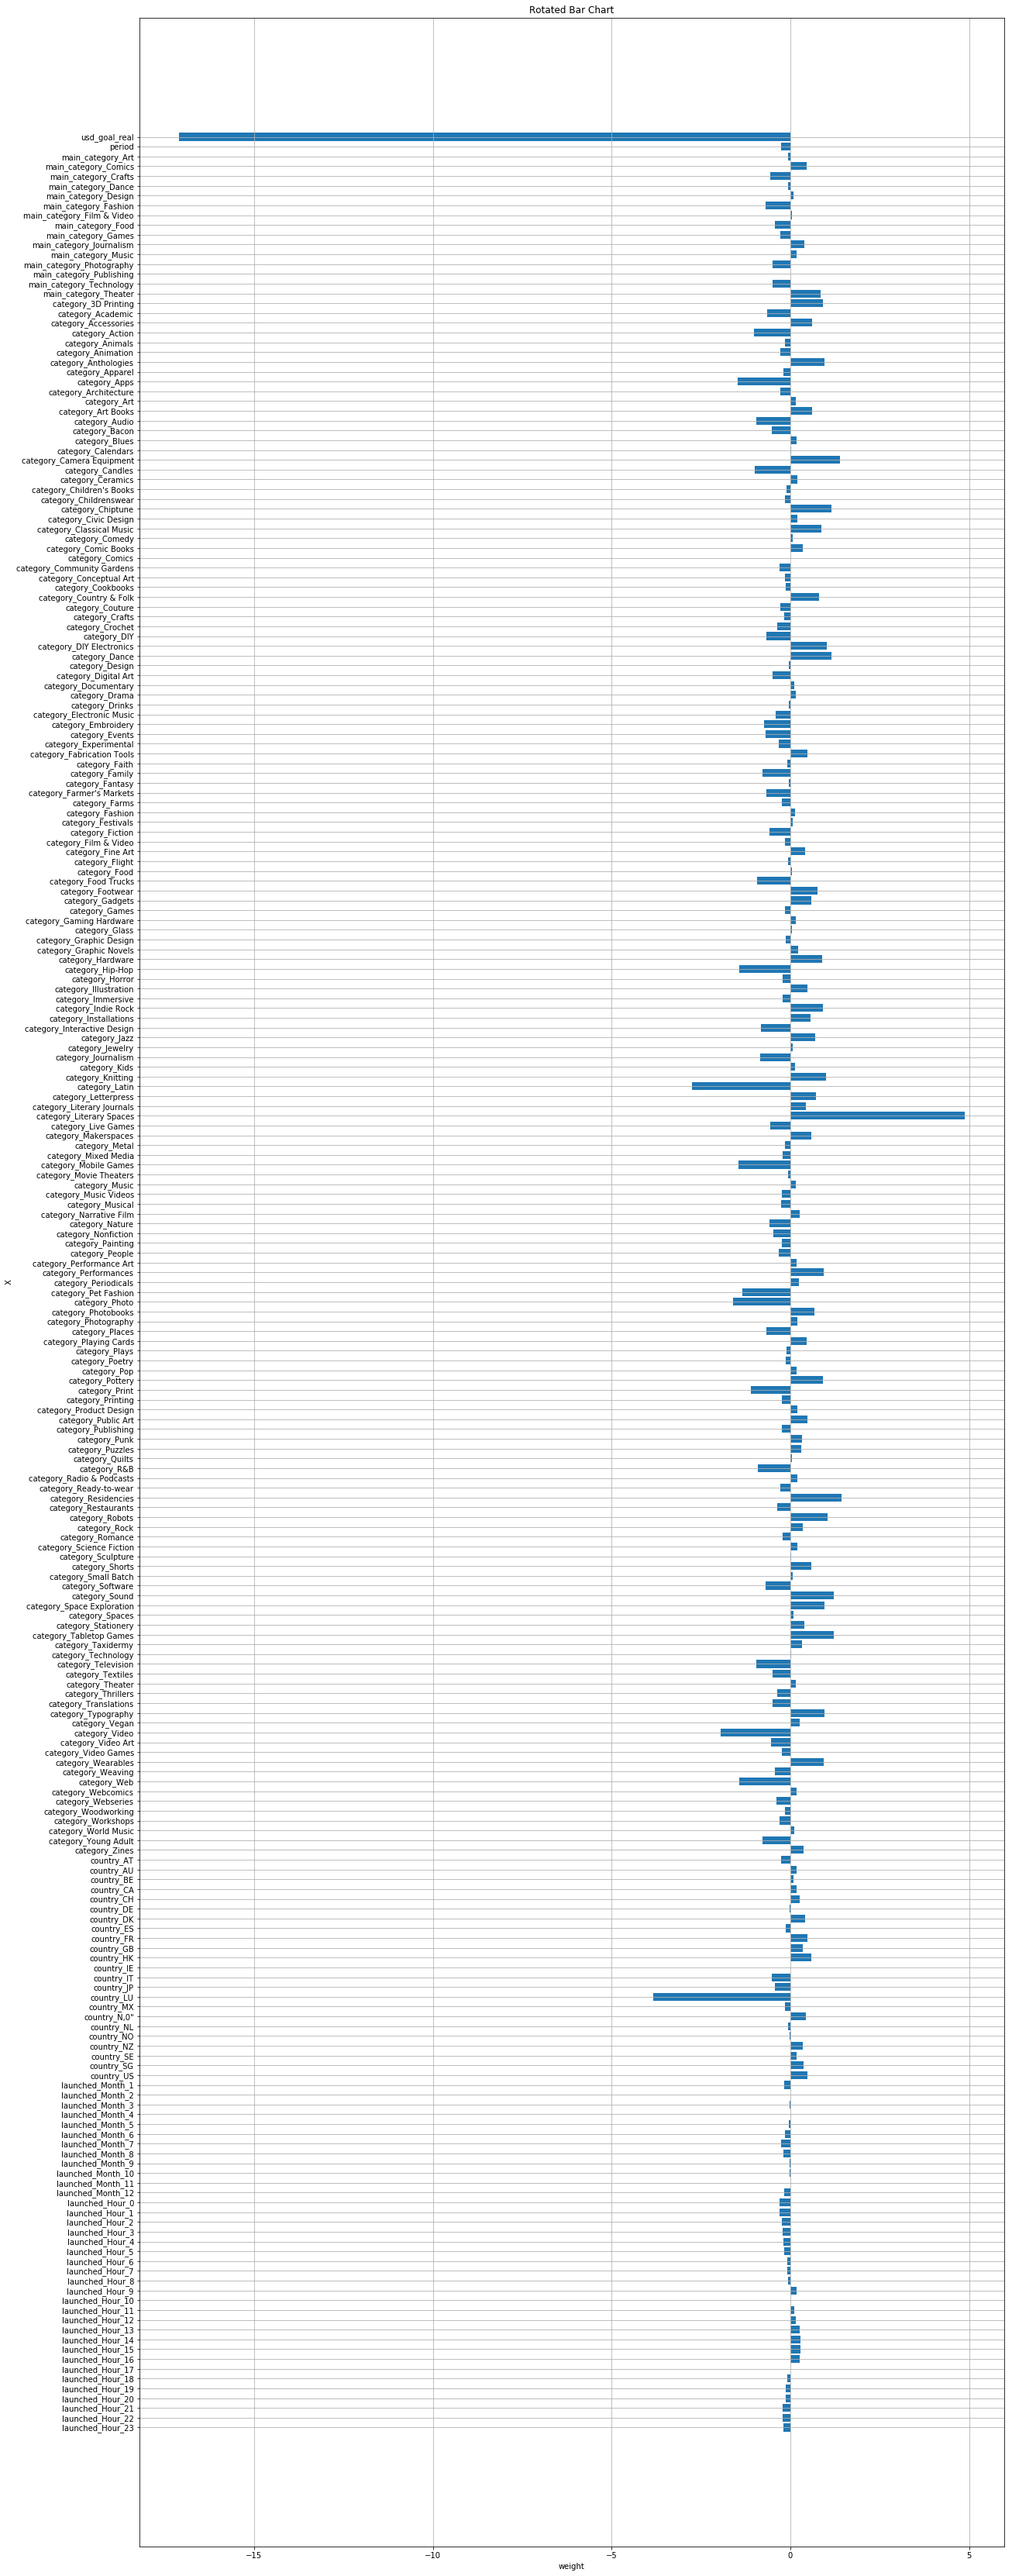

In [320]:
# ------------------------------------------------
# ◆ グラフ化  
# ------------------------------------------------
plt.figure(figsize=(20, 60))
plt.barh(np.arange(len(n_features))[::-1], fti, align='center')
plt.yticks(np.arange(len(n_features))[::-1], n_features)
plt.title('Rotated Bar Chart')
plt.xlabel('weight')
plt.ylabel('X')
plt.grid()
plt.show()

In [321]:
# ================================================
# ◆ 4.モデル評価
# ================================================
# ラベルを予測
y_est = clf.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)

# 成功に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat

対数尤度 = -11.340
正答率 = 67.168%
適合率（Precision） = 69.693%
再現率（Recall） = 79.492%
F1値（F1-score） = 74.271%


,予測 = 失敗,予測 = 成功
正解 = 失敗,157170,40547
正解 = 成功,68348,65608
